In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import OrderedDict

from cuda import cudart
from copy import deepcopy
import tensorrt as trt

import pycuda.driver as cuda
import pycuda.autoinit


In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


class ImageTensor:
    def __init__(self, image):
        self.image = image
        self.orig_width, self.orig_height = image.size
        self.resized_width, self.resized_height = None, None
        self.pad_width, self.pad_height = None, None

    def size(self):
        return self.image.size

    def apply_coords(self, coords: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension
        """
        old_h, old_w = self.orig_height, self.orig_width
        new_h, new_w = self.resized_height, self.resized_width
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords


class ImagePreprocessor:
    def __init__(self, long_side_max=1024, mean=None, std=None, image_format="RGB", pad_to_square=True):
        self.long_side_max = long_side_max
        self.mean = mean
        self.std = std
        self.image_format = image_format
        self.pad_to_square = pad_to_square
        if self.mean is None:
            self.mean = np.array([123.675, 116.28, 103.53])
        if self.std is None:
            self.std = np.array([58.395, 57.12, 57.375])


    def resize_image_to_long_side(self, img: ImageTensor):
        if self.long_side_max is None:
            return img
        orig_width, orig_height = img.image.size
        if orig_width > orig_height:
            img.resized_width = self.long_side_max
            img.resized_height = int(self.long_side_max / orig_width * orig_height)
        else:
            img.resized_height = self.long_side_max
            img.resized_width = int(self.long_side_max / orig_height * orig_width)

        img.image = img.image.resize((img.resized_width, img.resized_height), Image.Resampling.BILINEAR)
        return img

    def make_image_rgb(self, image):
        if image.image.mode == "RGB":
            return image
        else:
            image.image = image.image.convert("RGB")
            return image

    def pad_image_to_square(self, image):
        if isinstance(image, ImageTensor):
            image.image = self.pad_image_to_square(image.image)
            return image
        else:
            h, w = image.shape[2:]
            max_dim = max(h, w)
            pad_h = max_dim - h
            pad_w = max_dim - w
            image = np.pad(image, ((0,0), (0,0), (0,pad_h), (0,pad_w)), mode="constant", constant_values=0)
            return image

    def normalize_image(self, image):
        if isinstance(image, ImageTensor):
            image.image = self.normalize_image(image.image)
            return image
        else:
            image = (image - self.mean) / self.std
            return image

    def to_tensor(self, image):
        if isinstance(image, ImageTensor):
            image.image = self.to_tensor(image.image)
            return image
        else:
            image = image.transpose(2,0,1)[None,:,:,:].astype(np.float32)
            return image

    def from_image_to_input(self, image):
        image = self.make_image_rgb(image)
        image = self.resize_image_to_long_side(image)
        image = self.normalize_image(image)
        image = self.to_tensor(image)
        # pad to square
        if self.pad_to_square:
            image = self.pad_image_to_square(image)
        return image
    
def predict_encoder(batch): # result gets copied into output
    # transfer input data to device
    cuda.memcpy_htod_async(d_input, batch, stream)
    # execute model
    encoder_context.execute_async_v2(bindings, stream.handle, None)
    # transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)
    # syncronize threads
    stream.synchronize()
    
    return output

def get_shape_dict(batch, points):
    embed_dim = 256
    embed_size = (64, 64)
    mask_input_size = [4 * x for x in embed_size]

    return {
        "image_embeddings": (1, embed_dim, *embed_size),
        "point_coords": (batch, points, 2),
        "point_labels": (batch, points),
        "mask_input": (1, 1, *mask_input_size),
        "has_mask_input": (1, ),
        "iou_predictions": (batch, 4), # up to 4 masks per point
        "low_res_masks": (batch, 4, *mask_input_size), # up to 4 masks per point
    }

def get_param_dict(embeddings, image_embedding_size, device, point=(300,300)):
    input_point = torch.as_tensor(np.array([point]), device=device, dtype=torch.float32)
    input_label = torch.as_tensor(np.array([1]), device=device, dtype=torch.float32)
    zero_point = torch.zeros(1, 2, device=device, dtype=torch.float32)
    negative_label = torch.as_tensor(np.array([-1]), device=device, dtype=torch.float32)
    coord = torch.cat((input_point, zero_point), dim=0)[None, :, :]
    label = torch.cat((input_label, negative_label), dim=0)[None, :]
    dtype = torch.float32

    embeddings = torch.as_tensor(embeddings, dtype=dtype)

    mask_input = torch.zeros(1, 1, 4 * image_embedding_size[0], 
                                4 * image_embedding_size[1], device=device, dtype=dtype)
    has_mask_input = torch.zeros(1, dtype=dtype, device=device)


    params = {
        "image_embeddings": embeddings,
        "point_coords": coord,
        "point_labels": label,
        "mask_input": mask_input,
        "has_mask_input": has_mask_input,
    }
    return params

numpy_to_torch_dtype_dict = {
    bool : torch.bool,
    np.uint8 : torch.uint8,
    np.int8 : torch.int8,
    np.int16 : torch.int16,
    np.int32 : torch.int32,
    np.int64 : torch.int64,
    np.float16 : torch.float16,
    np.float32 : torch.float32,
    np.float64 : torch.float64,
    np.complex64 : torch.complex64,
    np.complex128 : torch.complex128
}

def _allocate_buffers(shape_dict, engine, context):
    for idx in range(engine.num_io_tensors):
        binding = engine[idx]
        print(binding)
        if shape_dict and binding in shape_dict:
            shape = shape_dict[binding]
            print(f"shape from dict: {shape}")
        else:
            shape = engine.get_binding_shape(binding)
            print(f"shape from engine: {shape}")

        dtype = trt.nptype(engine.get_tensor_dtype(binding))
        print(f"Engine dtype {dtype}")
        if engine.get_tensor_mode(binding) == trt.TensorIOMode.INPUT:
            context.set_input_shape( binding, shape)
            print("is input")
        else:
            print("is output")
        tensor = torch.empty(tuple(shape), dtype=numpy_to_torch_dtype_dict[dtype]).to(device=device)
        tensors[binding] = tensor

def CUASSERT(cuda_ret):
    err = cuda_ret[0]
    if err != cudart.cudaError_t.cudaSuccess:
         raise RuntimeError(f"CUDA ERROR: {err}, error code reference: https://nvidia.github.io/cuda-python/module/cudart.html#cuda.cudart.cudaError_t")
    if len(cuda_ret) > 1:
        return cuda_ret[1]
    return None

def infer_engine(stream, tensors, param_dict, context, use_cuda_graph=True, cuda_graph_instance=None):
    for name, buf in param_dict.items():
        tensors[name].copy_(buf)

    for name, tensor in tensors.items():
        context.set_tensor_address(name, tensor.data_ptr())

    if use_cuda_graph:
        if cuda_graph_instance is not None:
            CUASSERT(cudart.cudaGraphLaunch(cuda_graph_instance, stream.handle))
            CUASSERT(cudart.cudaStreamSynchronize(stream.handle))
        else:
            # do inference before CUDA graph capture
            noerror = context.execute_async_v3(stream.handle)
            if not noerror:
                raise ValueError(f"ERROR: inference failed.")
            # capture cuda graph
            CUASSERT(cudart.cudaStreamBeginCapture(stream.handle, cudart.cudaStreamCaptureMode.cudaStreamCaptureModeGlobal))
            context.execute_async_v3(stream.handle)
            graph = CUASSERT(cudart.cudaStreamEndCapture(stream.handle))
            cuda_graph_instance = CUASSERT(cudart.cudaGraphInstantiate(graph, 0))
    else:
        noerror = context.execute_async_v3(stream.handle)
        if not noerror:
            raise ValueError(f"ERROR: inference failed.")
        

    return tensors

def scale_tensor_with_aspect_ratio(tensor, max_size):
    # assumes tensor dimension (batch, height, width)
    height, width = tensor.shape[-2:]
    aspect_ratio = width / height
    if width > height:
        new_width = max_size
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = max_size
        new_width = int(new_height * aspect_ratio)
    # scale tensor dimes (batch, height, width)
    scaled_tensor_shape = (new_height, new_width)
    scaled_tensor = torch.nn.functional.interpolate(tensor, size=scaled_tensor_shape, mode='bilinear', align_corners=False)
    return scaled_tensor

def undo_pad_on_tensor(tensor, original_shape):
    n_dims = tensor.dim()
    width, height = original_shape[:2]
    # unpad the tensor
    if n_dims == 4:
        unpadded_tensor = tensor[:, :, :height, :width]
    elif n_dims == 3:
        unpadded_tensor = tensor[:, :height, :width]
    else:
        raise ValueError('Invalid tensor dimension')
    return unpadded_tensor

def visualize_point_and_mask(image, mask=None, point=None, labels=None, slice_idx=3):
    mask_slice = slice(slice_idx, slice_idx+1)
    mask = mask[:,mask_slice, :, :]
    aspect = plt.figaspect(image)
    fig, _ = plt.subplots(figsize=(aspect[0]*2, aspect[1]*2))
    fig.subplots_adjust(0,0,1,1)
    plt.imshow(image)
    if mask is not None:
        show_mask(mask.cpu().numpy(), plt.gca())
    if point:
        show_points(point, labels, plt.gca())
    plt.axis('off')

In [3]:
# load decoder
f = open("engine_fp32/decoder.engine", "rb")
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
decoder_engine = runtime.deserialize_cuda_engine(f.read())
decoder_context = decoder_engine.create_execution_context()

# load encoder
f = open("engine_fp32/encoder.engine", "rb")
encoder_engine = runtime.deserialize_cuda_engine(f.read())
encoder_context = encoder_engine.create_execution_context()

image_embeddings
shape from dict: (1, 256, 64, 64)
Engine dtype <class 'numpy.float32'>
is input
point_coords
shape from dict: (1, 2, 2)
Engine dtype <class 'numpy.float32'>
is input
point_labels
shape from dict: (1, 2)
Engine dtype <class 'numpy.float32'>
is input
mask_input
shape from dict: (1, 1, 256, 256)
Engine dtype <class 'numpy.float32'>
is input
has_mask_input
shape from dict: (1,)
Engine dtype <class 'numpy.float32'>
is input
iou_predictions
shape from dict: (1, 4)
Engine dtype <class 'numpy.float16'>
is output
low_res_masks
shape from dict: (1, 4, 256, 256)
Engine dtype <class 'numpy.float16'>
is output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


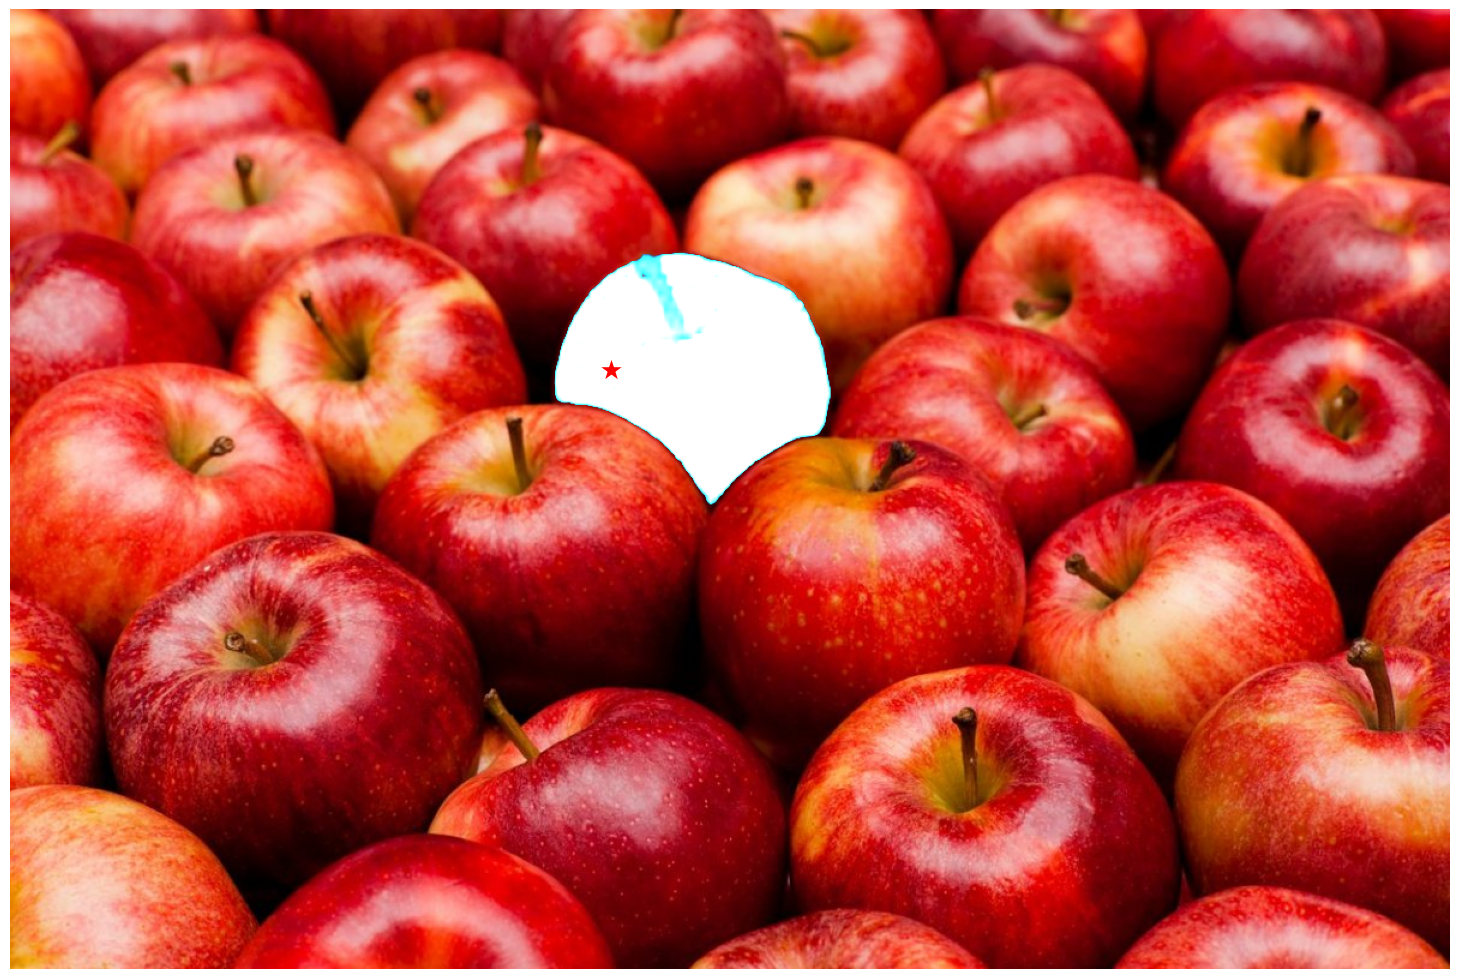

In [4]:
# data loading
# open sample file
image_path = R"/workspace/sam_trt_pipeline/images/apples.jpg"
image = Image.open(image_path)
original_image_shape = image.size
image_numpy = np.array(image)
# image collections for plotting and testing
image_original = ImageTensor(image)
image_object = ImageTensor(image)

# image processor object
image_preprocessor = ImagePreprocessor()

image_rgb = image_preprocessor.make_image_rgb(image_object)
numpy_image = np.array(image_rgb.image)
input_image = image_preprocessor.from_image_to_input(image_object)
input_tensor = input_image.image

device = "cuda"
stream = cuda.Stream()



# apply encoder
BATCH_SIZE = 1
USE_FP16 = False
target_dtype = np.float16 if USE_FP16 else np.float32
# need to set input and output precisions to FP16 to fully enable it
output = np.empty([BATCH_SIZE, 256, 64, 64], dtype = target_dtype) 
# allocate device memory for encoder
d_input = cuda.mem_alloc(1 * input_tensor.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)
bindings = [int(d_input), int(d_output)]
pred = predict_encoder(input_tensor)

# apply decoder
tensors = OrderedDict()
point = (500, 300)
point_plotting = np.array([point]), np.array([1]),
decoder_shape_dict = get_shape_dict(1, 2)
decoder_params = get_param_dict(embeddings=pred, image_embedding_size=(64, 64), device=device, point=point)
_allocate_buffers(decoder_shape_dict, decoder_engine, decoder_context)
outputs = infer_engine(stream, tensors, decoder_params, decoder_context, use_cuda_graph=True)

masks = outputs['low_res_masks']
scores = outputs['iou_predictions']

scaled_tensor = scale_tensor_with_aspect_ratio(masks, np.max(original_image_shape))
unpadded_tensor = undo_pad_on_tensor(scaled_tensor, original_image_shape)

visualize_point_and_mask(image_numpy, mask=unpadded_tensor, slice_idx=2, point=point_plotting)